---
---

# **Audio Classification**

We will follow the below scheme

![image.png](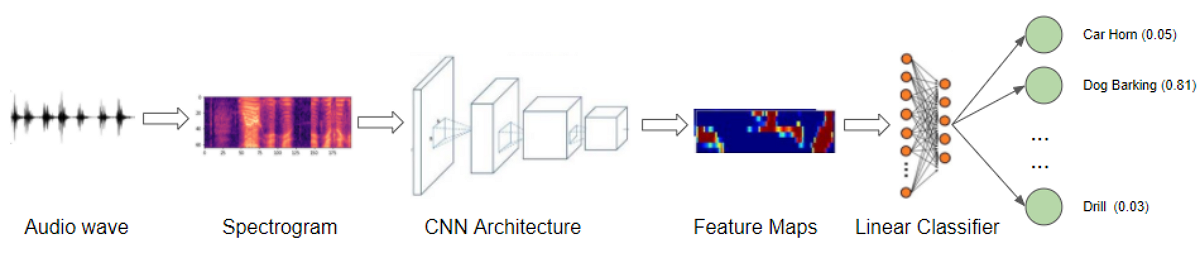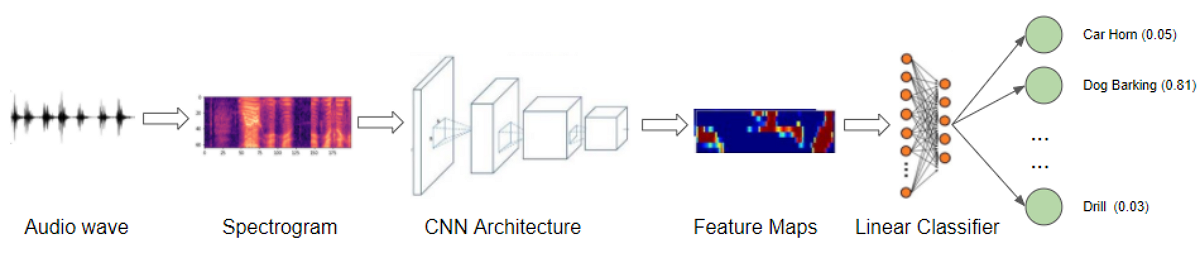)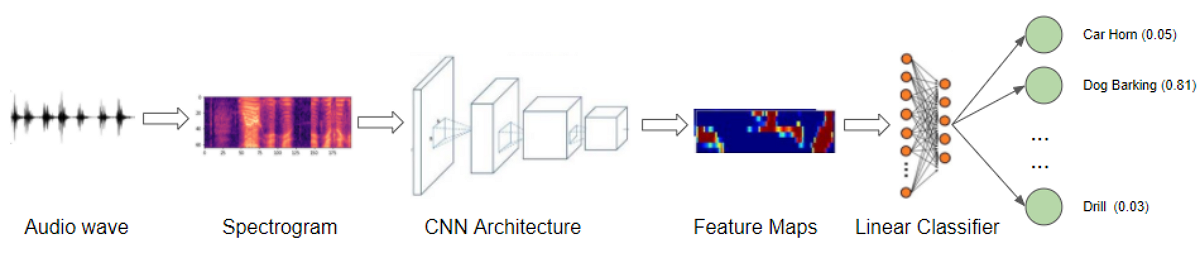

In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
!unzip dataset_audio.zip

--2022-06-30 21:57:28--  https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... ^C
unzip:  cannot find or open dataset_audio.zip, dataset_audio.zip.zip or dataset_audio.zip.ZIP.


In [ ]:
!unzip dataset_audio.zip

---
---
# **Preprocessing**

In [ ]:
!pip install tensorflow_io
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.pyplot as plt

from keras import initializers
from pydub import AudioSegment
from sklearn import preprocessing
from scipy.io.wavfile import read
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
def delete_excess(data):
  return data[:length_audio]

def add_average(data):
  result = np.zeros(shape=(length_audio,))
  end = data.shape[0]
  mean = np.mean(data[end-25:])
  result[:end] = data
  result[end:] = mean
  return result

def plot_spectrogram(spectrogram, ax, title, rate):
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
  ax.set_xlim([0, rate])
  ax.set_title(title)

In [ ]:
directory = "./dataset_audio/"
file_name = "I0474.wav"
path = directory + file_name

rate, data = read(path)

length = data.shape[0] / rate   # 
length_audio = data.shape[0]    # 176400
nb_channels = data.shape[1]     # 2

n_samples = 0
for file_name in os.listdir(directory):
  n_samples += 1

dataset = np.zeros(shape=(n_samples, length_audio))

# creating the dataset and labels
labels = np.zeros(shape=(n_samples,))

for index, filename in enumerate(os.listdir(directory)):
  if filename[0] == 'I': labels[index] = 1
  path = directory + filename
  rate, data = read(path)
  data = np.mean(data,axis=1)
  dim = data.shape
  if dim != (length_audio, nb_channels):
    if dim[0] > length_audio:
      result = delete_excess(data)
    else:
      result = add_average(data)
    dataset[index] = result
  else:
    dataset[index] = data

dataset = (dataset - np.mean(dataset)) / np.std(dataset)  # let's normalize

print("----------------------------------")
print("| dataset.shape: ", dataset.shape)
print("| labels.shape : ", labels.shape)
print("----------------------------------")

----------------------------------
| dataset.shape:  (200, 176400)
| labels.shape :  (200,)
----------------------------------


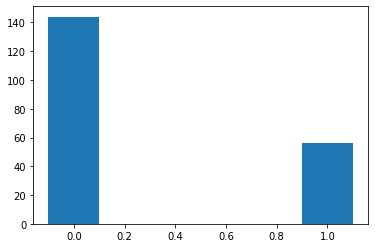

In [ ]:
# let's separate indor and outdoor data

args_indoor  = np.argwhere(labels==1)
args_outdoor = np.argwhere(labels==0)

dataset_indoor  = dataset[args_indoor].squeeze()
dataset_outdoor = dataset[args_outdoor].squeeze()

plt.bar([0,1], [dataset_outdoor.shape[0], dataset_indoor.shape[0]], width=0.2);

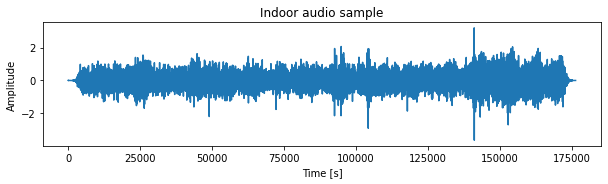

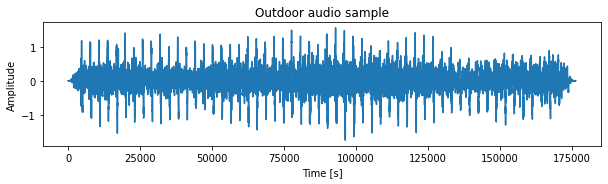

In [ ]:
timesteps = np.arange(dataset.shape[1])

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, dataset_indoor[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Indoor audio sample")
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,2)
plt.plot(timesteps, dataset_outdoor[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Outdoor audio sample")
plt.show()

In [ ]:
# transformation to spectrogram

frame_length = 685
frame_step = int(frame_length/2)

spectrogram_indoor  = tf.abs(tf.signal.stft(signals=dataset_indoor, frame_length=frame_length, frame_step=frame_step, fft_length=None))
spectrogram_outdoor = tf.abs(tf.signal.stft(signals=dataset_outdoor, frame_length=frame_length, frame_step=frame_step, fft_length=None))

print("-----------------------------------------------")
print("|  dataset_indoor.shape:", dataset_indoor.shape)
print("|  spectrogram_indoor.shape:", spectrogram_indoor.shape)
print("-----------------------------------------------")
print("|  dataset_outdoor.shape:", dataset_outdoor.shape)
print("|  spectrogram_outdoor.shape:", spectrogram_outdoor.shape)
print("-----------------------------------------------")

-----------------------------------------------
|  dataset_indoor.shape: (56, 176400)
|  spectrogram_indoor.shape: (56, 514, 513)
-----------------------------------------------
|  dataset_outdoor.shape: (144, 176400)
|  spectrogram_outdoor.shape: (144, 514, 513)
-----------------------------------------------


In [ ]:
ipd.Audio(dataset_indoor[0,:], rate=rate)

In [ ]:
ipd.Audio(dataset_outdoor[0,:], rate=rate)

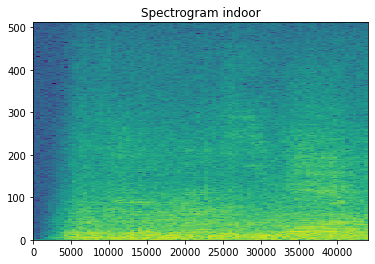

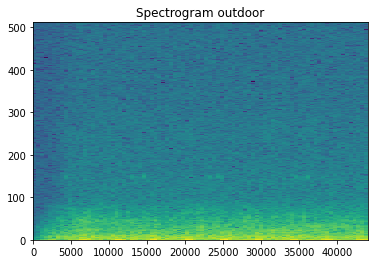

In [ ]:
fig, ax = plt.subplots()  
plot_spectrogram(spectrogram_indoor[0,:].numpy(), ax, 'Spectrogram indoor', rate)
plt.show()

fig, ax = plt.subplots()  
plot_spectrogram(spectrogram_outdoor[0,:].numpy(), ax, 'Spectrogram outdoor', rate)
plt.show()

---
---
# **Model Building**

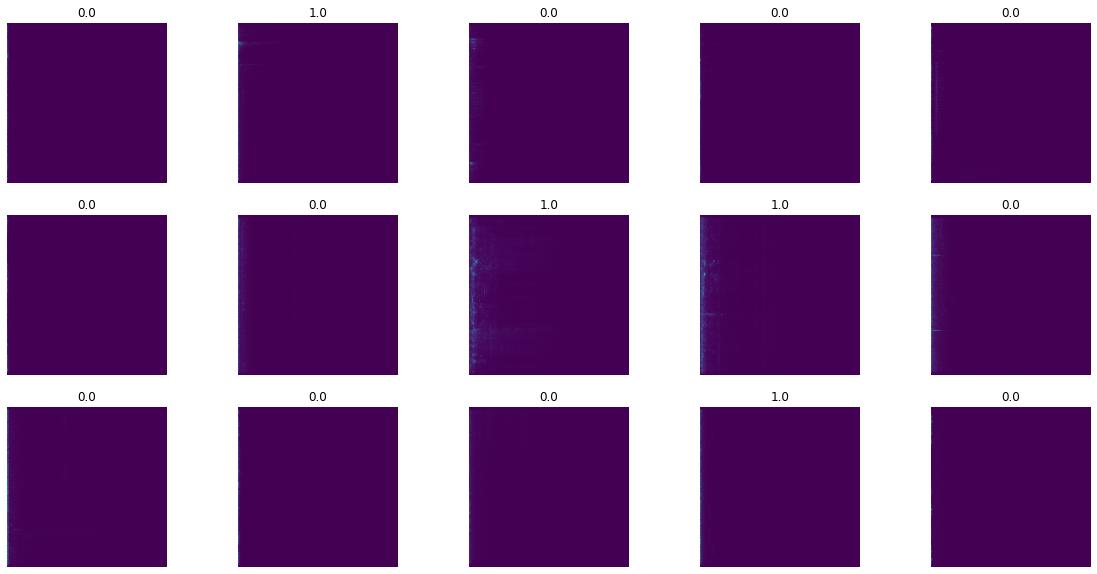

In [ ]:
# dataset creation

BATCH_SIZE  = 15
BUFFER_SIZE = 200

labels = np.zeros(shape=(n_samples,))
labels[:spectrogram_indoor.shape[0]] = 1

merge = np.concatenate((spectrogram_indoor, spectrogram_outdoor), axis=0)
merge = (merge - np.mean(merge)) / np.std(merge)

# shuffle

arg_shuffle = np.random.choice(n_samples, size=(n_samples), replace=False)

dataset = merge[arg_shuffle].reshape(merge.shape[0], merge.shape[1], merge.shape[2], 1)
labels  = labels[arg_shuffle]

plt.figure(figsize=(20, 10))
for index, images in enumerate(dataset[:15,:,:]):
  ax = plt.subplot(3, 5, index + 1)
  plt.imshow(images[:,:,0])
  plt.title(labels[index])
  plt.axis("off")

In [ ]:
def get_model():

  model = tf.keras.Sequential()

  model.add(layers.Input(shape=(dataset.shape[1], dataset.shape[2], dataset.shape[3])))

  model.add(layers.Resizing(256, 256))

  model.add(layers.Conv2D(512, (6,6), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (4,4), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(64, (2,2), strides=(2,2), padding='same', activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dense(1))

  optimizer = Adam(0.00002, beta_1=0.1)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 512)     18944     
                                                                 
 dropout (Dropout)           (None, 128, 128, 512)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 512)       6554112   
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       2097408   
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 256)       0

---
---
# **Training**

In [ ]:
epochs=100

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(dataset, labels, epochs=epochs, validation_split=0.3, callbacks=[callback])

Epoch 1/100
5/5 [==============================] - 42s 4s/step - loss: 1.6676 - binary_accuracy: 0.7143 - val_loss: 1.0374 - val_binary_accuracy: 0.7333
Epoch 2/100
5/5 [==============================] - 6s 1s/step - loss: 1.0245 - binary_accuracy: 0.7143 - val_loss: 0.8417 - val_binary_accuracy: 0.7333
Epoch 3/100
5/5 [==============================] - 6s 1s/step - loss: 0.8478 - binary_accuracy: 0.7143 - val_loss: 0.7275 - val_binary_accuracy: 0.7333
Epoch 4/100
5/5 [==============================] - 6s 1s/step - loss: 0.7457 - binary_accuracy: 0.7143 - val_loss: 0.6548 - val_binary_accuracy: 0.7333
Epoch 5/100
5/5 [==============================] - 6s 1s/step - loss: 0.6822 - binary_accuracy: 0.7143 - val_loss: 0.6166 - val_binary_accuracy: 0.7333
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 0.6445 - binary_accuracy: 0.7143 - val_loss: 0.5959 - val_binary_accuracy: 0.7333
Epoch 7/100
5/5 [==============================] - 7s 1s/step - loss: 0.6257 - binary_a

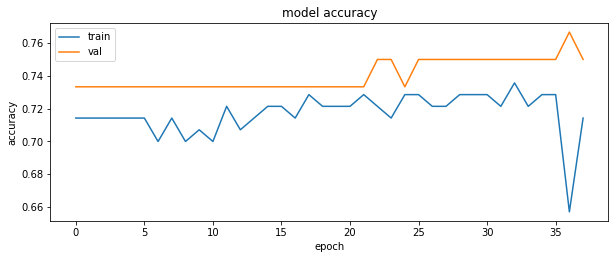

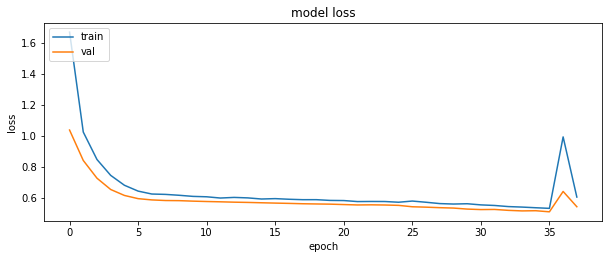

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
number_splits = 6
number_runs   = 5
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(dataset, labels)):

    model = get_model()
    print("Training the fold number ", fold_no,"\n")
    history = model.fit(dataset[fold_train], labels[fold_train], epochs=50, callbacks=[callback])

    scores = model.evaluate(dataset[fold_test], labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)




Doing the run number  1
Training the fold number  1 

Epoch 1/50
6/6 [==============================] - 8s 1s/step - loss: 1.4784 - binary_accuracy: 0.7108
Epoch 2/50
6/6 [==============================] - 7s 1s/step - loss: 0.9393 - binary_accuracy: 0.7108
Epoch 3/50
6/6 [==============================] - 7s 1s/step - loss: 0.7742 - binary_accuracy: 0.7108
Epoch 4/50
6/6 [==============================] - 7s 1s/step - loss: 0.6821 - binary_accuracy: 0.7048
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 0.6248 - binary_accuracy: 0.7108
Epoch 6/50
6/6 [==============================] - 7s 1s/step - loss: 0.6104 - binary_accuracy: 0.7108
Epoch 7/50
6/6 [==============================] - 7s 1s/step - loss: 0.6033 - binary_accuracy: 0.7169
Epoch 8/50
6/6 [==============================] - 7s 1s/step - loss: 0.6045 - binary_accuracy: 0.7108
Epoch 9/50
6/6 [==============================] - 7s 1s/step - loss: 0.5924 - binary_accuracy: 0.7289
Epoch 10/50
6/6 [========

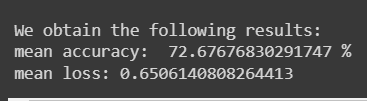